In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read in data
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

## Explore 

In [3]:
values, counts = np.unique(train_data['outcome'], return_counts=True)
print(counts)
# there are ~10x more 0s than 1s

[9018  982]


In [4]:
# Copy and combine datasets for manipulation

X = train_data.copy()
X_test = test_data.copy()
combined = [X, X_test]

# alpha -> numeric
device_dict = {'iPhone':0, 'desktop':1, 'laptop':2, 'Android':3, 'other':4}

for dataset in combined:
    dataset['gender'].fillna("Missing", inplace=True) 
    dataset['gender'] = dataset['gender'].map( {'M': 0, 'F': 1, 'Missing':2} ).astype(int)
    dataset['device_type'] = dataset['device_type'].map(device_dict).astype(int)


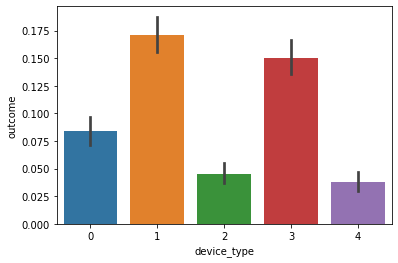

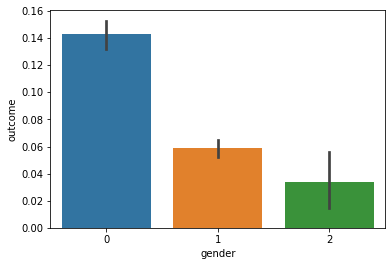

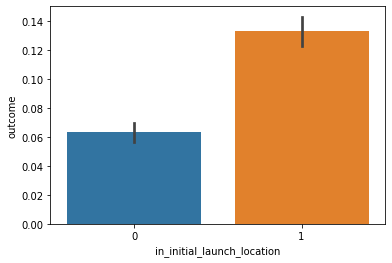

In [5]:
sns.barplot(X['device_type'], X['outcome'])
plt.show()
sns.barplot(X['gender'], X['outcome'])
plt.show()
sns.barplot(X['in_initial_launch_location'], X['outcome'])
plt.show()

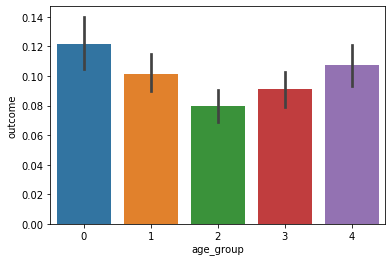

In [6]:
def make_group(var, var_upper_lims):
    for index,lim in enumerate(var_upper_lims): 
        if var < lim:
            return index

#age
age_upper_lims = [22,32,42,52,62]
for dataset in combined: 
    dataset['age_group'] = dataset["age"].apply(make_group, args=([age_upper_lims]))
    
sns.barplot(X['age_group'], X['outcome'])
plt.show()

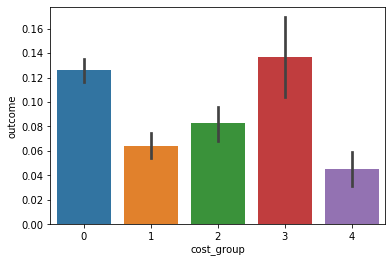

In [7]:
# cost
results, bin_edges = pd.qcut(X['cost_of_ad'], q=5, retbins=True)
cost_upper_lims = bin_edges[1:]+.1*bin_edges[-1]

for dataset in combined: 
    dataset['cost_group'] = dataset["cost_of_ad"].apply(make_group, args=([cost_upper_lims]))  
sns.barplot(X['cost_group'], X['outcome'])
plt.show()

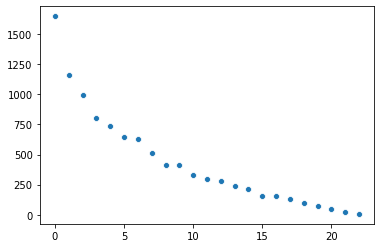

In [8]:
# prior insurance tenure
values, counts = np.unique(X.prior_ins_tenure, return_counts=True)
sns.scatterplot(values, counts)
plt.show()

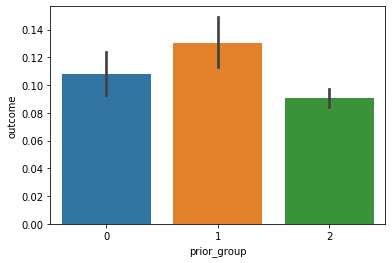

[1, 2, 25]

In [9]:
prior_upper_lims = [1,2,25]
for dataset in combined: 
    dataset['prior_group'] = dataset["prior_ins_tenure"].apply(make_group, args=([prior_upper_lims]))  
sns.barplot(X['prior_group'], X['outcome'])
plt.show()
prior_upper_lims

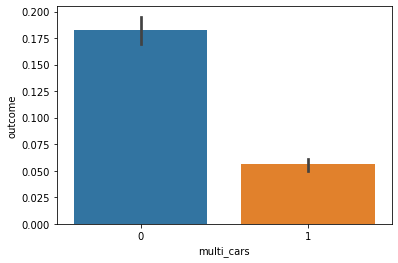

In [10]:
car_upper_lims = [2,4]

for dataset in combined: 
    dataset['multi_cars'] = dataset["n_vehicles"].apply(make_group, args=([car_upper_lims]))  
sns.barplot(X['multi_cars'], X['outcome'])
plt.show()

In [11]:
vars_to_drop = ['age','income','cost_of_ad',
                'n_vehicles','prior_ins_tenure'
               ]
for dataset in combined:
    dataset.drop(vars_to_drop, axis=1, inplace=True)

## Model

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import (cross_val_score, 
                                     RepeatedStratifiedKFold)

In [13]:
# split y from X in the training data
y = X['outcome'].tolist()
X.drop(['outcome'], axis=1, inplace=True)

In [14]:
# Split training data
train_X, val_X, train_y, val_y = train_test_split(X,y,random_state=10, test_size=0.2, stratify=y)

# Random Forest
rfmodel = RandomForestClassifier(random_state=10)
over = SMOTE(random_state=10, sampling_strategy=.2)
under = RandomUnderSampler(random_state=10, sampling_strategy=.5)
steps = [('scaler', StandardScaler()),
         ('o', over), ('u', under), 
         ('model', rfmodel)]
pipeline = Pipeline(steps=steps)


In [15]:
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'model__n_estimators': [100, 200], 
    'model__max_features': ['auto', 'sqrt', 'log2'],
    'model__max_depth' : [7,8,10],
    'model__criterion' :['gini', 'entropy']
}
rf_gs = GridSearchCV(estimator=pipeline,cv=5,
              scoring='roc_auc', n_jobs=1,
              param_grid=param_grid)

In [16]:
rf_gs.fit(train_X, train_y)
rf_gs.best_params_

{'model__criterion': 'entropy',
 'model__max_depth': 8,
 'model__max_features': 'log2',
 'model__n_estimators': 100}

In [17]:
# Random Forest with optimized params, could have used 
rfmodel2 = RandomForestClassifier(random_state=10, criterion='entropy',
                                 max_depth=8, max_features='log2', 
                                 n_estimators=100)
steps2 = [('scaler', StandardScaler()),
          ('o', over), ('u', under),
          ('model', rfmodel2)]
pipeline2 = Pipeline(steps=steps2)

# evaluate pipeline2
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline2, val_X, val_y, scoring='roc_auc', cv=cv, n_jobs=1)
score = np.mean(scores)
print('Mean ROC AUC: %.3f' % (score))

Mean ROC AUC: 0.853


## Train on full training dataset, make predictions for test.csv

In [18]:
# apply model using all X as training data
pipeline2.fit(X, y)
preds = pipeline2.predict(X_test)
preds[:5]

array([0, 1, 0, 0, 0])